# Drug seller analysis

In [210]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sbn
from IPython.core.display import HTML
sbn.set_style('darkgrid')
%matplotlib inline

## 1. Predicting Bad Trips Using Logistic Regression

http://analyticsmadeskeezy.com/2013/04/25/prediction-intervals/

In [28]:
df_raw_bad_trip = pd.read_csv('1.LogistcRegressionLSD.csv')
df_raw_bad_trip.head()

,Gender,Height,Attire,Tattooed,Jittery,Fav Product,Phone,Bad?
0,1,63,10,1,1,Coke,Android,1
1,0,67,9,0,0,Coke,None,1
2,0,71,8,0,0,X,Android,1
3,0,68,9,1,1,Coke,None,1
4,0,66,8,0,1,Meth,iPhone,1


In [31]:
df_ca_cols = df_raw_bad_trip[['Fav Product', 'Phone']]
df_ca_cols_vec = pd.get_dummies(df_ca_cols)
df_bad_trip = df_raw_bad_trip.drop(['Fav Product', 'Phone'], axis=1) \
                             .join(df_ca_cols_vec)
df_bad_trip.head()

,Gender,Height,Attire,Tattooed,Jittery,Bad?,Fav Product_Coke,Fav Product_Ketamine,Fav Product_LSD,Fav Product_Meth,Fav Product_Shrooms,Fav Product_Weed,Fav Product_X,Phone_Android,Phone_Blackberry,Phone_Flip,Phone_None,Phone_iPhone
0,1,63,10,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0
1,0,67,9,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
2,0,71,8,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
3,0,68,9,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0
4,0,66,8,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1


In [274]:
X = df_bad_trip.drop('Bad?', axis=1)
y = df_bad_trip['Bad?']
Xc = sm.add_constant(X)
logit = sm.Logit(y, Xc)
results = logit.fit(method='powell', maxiter=100)
print results.summary()

Optimization terminated successfully.
         Current function value: 0.305397
         Iterations: 10
         Function evaluations: 1920
                           Logit Regression Results                           
Dep. Variable:                   Bad?   No. Observations:                  100
Model:                          Logit   Df Residuals:                       84
Method:                           MLE   Df Model:                           15
Date:                Sun, 04 Oct 2015   Pseudo R-squ.:                  0.5583
Time:                        00:14:39   Log-Likelihood:                -30.540
converged:                       True   LL-Null:                       -69.135
                                        LLR p-value:                 2.271e-10
                           coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.2792   1.54e+07   1.81e

In [275]:
from sklearn import linear_model
clf = linear_model.LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [97]:
df = pd.DataFrame(zip(X.columns.values, clf.coef_[0]))
df.columns = ['Feature', 'Coef']
df

,Feature,Coef
0,Gender,0.261954
1,Height,-0.048976
2,Attire,0.564646
3,Tattooed,-1.387808
4,Jittery,0.823602
5,Fav Product_Coke,0.468657
6,Fav Product_Ketamine,-0.846754
7,Fav Product_LSD,-0.493235
8,Fav Product_Meth,1.049947
9,Fav Product_Shrooms,-0.791269


### predicting the probability of a bad trip

In [102]:
new = np.array([1,62,4,0,1,1,0,0,0,0,0,0,0,1,0,0,0])
newc = np.array([1,1,62,4,0,1,1,0,0,0,0,0,0,0,1,0,0,0])
print clf.predict_proba(new)[0][1]
print results.predict(newc)[0]

0.869531478031
0.974685057658


## 2. Predicting Monthly Demand

http://analyticsmadeskeezy.com/2012/11/15/forecasting-made-skeezy-projecting-meth-demand-using-exponential-smoothing/

In [170]:
df_raw_demand = pd.read_csv('2.ExponentialSmoothing.csv')
df_raw_demand.head()

,Year,Month,Demand
0,2008,January,48.40
1,2008,February,48.50
2,2008,March,57.45
3,2008,April,64.95
4,2008,May,62.55


In [212]:
mon_dic = dict(zip(df_raw_demand['Month'].unique(), range(1,13)))
df = df_raw_demand
df['Month'] = df['Month'].apply(lambda x: mon_dic[x])
df.index = pd.to_datetime((df['Year']*10000+df['Month']*100+1).apply(str), format='%Y%m%d')
df = df.drop(['Year', 'Month'], axis=1)

In [267]:
df['Demand'].values

array([ 48.4  ,  48.5  ,  57.45 ,  64.95 ,  62.55 ,  60.15 ,  69.25 ,
        68.6  ,  65.05 ,  64.4  ,  56.45 ,  48.   ,  53.583,  48.018,
        62.116,  67.681,  66.78 ,  70.066,  71.073,  76.691,  66.992,
        61.533,  62.275,  51.675,  60.146,  56.434,  67.222,  70.76 ,
        73.95 ,  79.286,  77.372,  79.808,  71.978,  70.702,  65.946,
        55.274,  61.08 ,  59.7  ,  69.48 ,  77.34 ,  74.16 ,  83.04 ,
        80.16 ,  81.12 ,  84.12 ,  69.   ,  68.4  ,  54.54 ,  66.624,
        58.048,  70.528,  79.424,  79.232,  93.056,  93.76 ,  93.696,
        94.08 ,  82.624,  75.776,  58.048])

In [297]:
clf = linear_model.LinearRegression()
X = np.array(range(df.shape[0])).reshape(df.shape[0], 1)
y = df['Demand'].values
clf.fit(X, y)
y_predict = clf.predict(X)

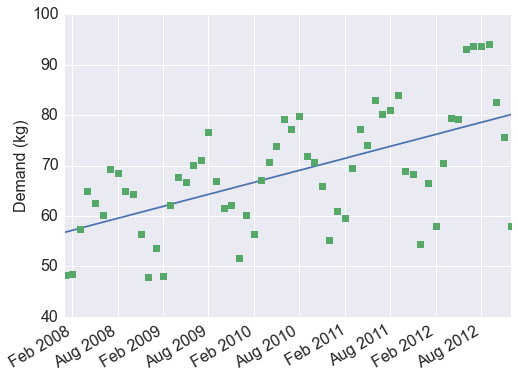

In [335]:
fig, ax = plt.subplots()
plt.plot(df.index, y_predict)
df.plot(figsize=(8, 6), 
        fontsize=12,
        ax=ax,
        style='s')
ax.set_ylabel('Demand (kg)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend_.remove()
plt.show()

## 3. Holt-Winters Exponential Smoothing

http://analyticsmadeskeezy.com/2013/04/25/prediction-intervals/

## 4. Intrusion Detection - How to Identify the Judas?

http://analyticsmadeskeezy.com/2012/11/29/intrusion-detection-made-skeezy-how-do-you-find-the-dea-in-a-haystack/

"He turned and looked at me, “There’s a fox in my henhouse.”"

"A coke supplier is all I know. They’ve set a trap for me and some of my competition. But I don’t know which supplier."

In [227]:
df_raw_supplier = pd.read_csv('3.OutlierDetection.csv')
HTML(df_raw_supplier.to_html())

,Name,Operate Own Transpo?,Border Method,Counterintel?,Jimbo,Stevie,Margalo,Criminal Record?,Need to meet?,# Past Deals w/ Them,Max Qty Avail,Price ($/kg)
0,Abraham,N,SHIPPING CONTAINER,N,N,N,N,Y,Y,0,722,7026
1,Aleksey,N,GO-FAST BOAT,N,N,N,N,N,Y,0,903,6856
2,Alex,Y,MULE,N,Y,N,N,N,Y,0,587,7094
3,Alexandr,N,SHIPPING CONTAINER,N,N,N,N,N,Y,1,957,7048
4,Alexey,N,MULE,N,Y,N,N,N,Y,0,990,7108
5,Alina,N,RESERVATION,N,N,Y,Y,N,Y,0,751,7062
6,Alyona,N,MULE,N,Y,N,N,Y,Y,0,920,7328
7,Amado,N,RESERVATION,N,N,N,N,Y,Y,2,694,6898
8,Amro,Y,SHIPPING CONTAINER,N,N,N,Y,Y,Y,0,695,7376
9,Anastasia,Y,SHIPPING CONTAINER,N,Y,N,Y,Y,Y,0,748,7144


Trying to find the outlier, Victor naively looked into the numerical columns and calculated the mean and standard deviation for each column.

In [82]:
df_nu = df_raw_supplier[['Max Qty Avail', 'Price ($/kg)']]
df_nu.describe().iloc[1:3]

,Max Qty Avail,Price ($/kg)
mean,1298.947791,7197.542169
std,1163.611966,268.845649


      Max Qty Avail  Price ($/kg)
mean    1298.947791   7197.542169
std     1163.611966    268.845649


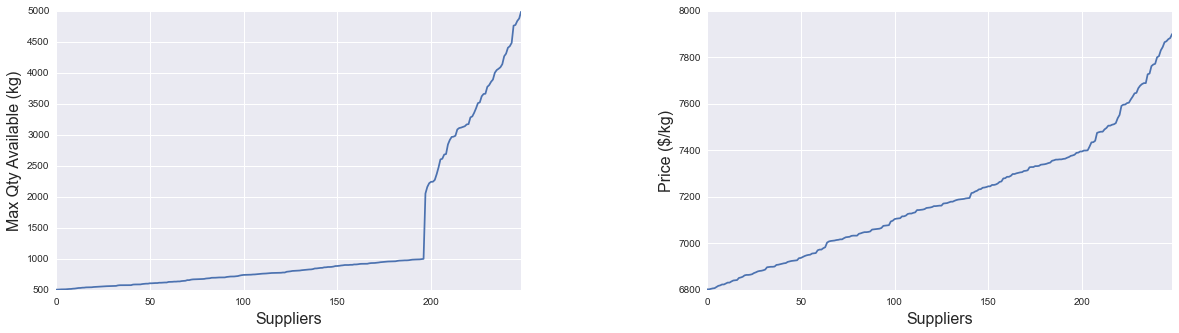

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
fig.subplots_adjust(wspace=0.4)

# Max Qty plot
ax1 = df_nu.sort(['Max Qty Avail']).reset_index()['Max Qty Avail'].plot(ax=axes[0])
ax1.set_ylabel('Max Qty Available (kg)', fontsize=16)
ax1.set_xlabel('Suppliers', fontsize=16)

# Price plot
ax2= df_nu.sort(['Price ($/kg)']).reset_index()['Price ($/kg)'].plot(ax=axes[1])
ax2.set_ylabel('Price ($/kg)', fontsize=16)
ax2.set_xlabel('Suppliers', fontsize=16)

There are several problems when analyzing data in this way: 
1. We may not be able to find the outlier by only looking at each (numerical) feature individually. We need to consider all the features in a holistical way. </br>
2. Taking means and standard deviations are terrible for finding outliers in this case because the data is oddly distributed. Moreover, when we calculate mean and standard deviation we also include the outliers. 

First, we need to do some feature transformations.

In [228]:
# categorical to binary 
ca_features = ['Border Method']
df_ca_cols = df_raw_supplier[ca_features]
df_ca_cols_vec = pd.get_dummies(df_ca_cols)
df_ca_cols_vec = df_ca_cols_vec.applymap(lambda x: -1 if x == 0 else 1)
df_supplier = df_raw_supplier.drop(ca_features, axis=1) \
                             .join(df_ca_cols_vec)

# Y&N to binary 
df_supplier = df_supplier.replace(['Y', 'N'], [1, -1])

df_supplier = df_supplier.set_index(['Name'])
df_supplier.head()

,Operate Own Transpo?,Counterintel?,Jimbo,Stevie,Margalo,Criminal Record?,Need to meet?,# Past Deals w/ Them,Max Qty Avail,Price ($/kg),Border Method_GO-FAST BOAT,Border Method_MULE,Border Method_RESERVATION,Border Method_SHIPPING CONTAINER,Border Method_SUB
Name,,,,,,,,,,,,,,,
Abraham,-1,-1,-1,-1,-1,1,1,0,722,7026,-1,-1,-1,1,-1
Aleksey,-1,-1,-1,-1,-1,-1,1,0,903,6856,1,-1,-1,-1,-1
Alex,1,-1,1,-1,-1,-1,1,0,587,7094,-1,1,-1,-1,-1
Alexandr,-1,-1,-1,-1,-1,-1,1,1,957,7048,-1,-1,-1,1,-1
Alexey,-1,-1,1,-1,-1,-1,1,0,990,7108,-1,1,-1,-1,-1


### Local Outlier Factor Algorithm (LOF)

Local Outlier Factor Algorithm (LOF) is used for detecting the local outliers, which are data points that look more different from their closest peers. Detail can be found in this <a href="http://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf">Paper</a> by Breunig <i>et. al</i>.

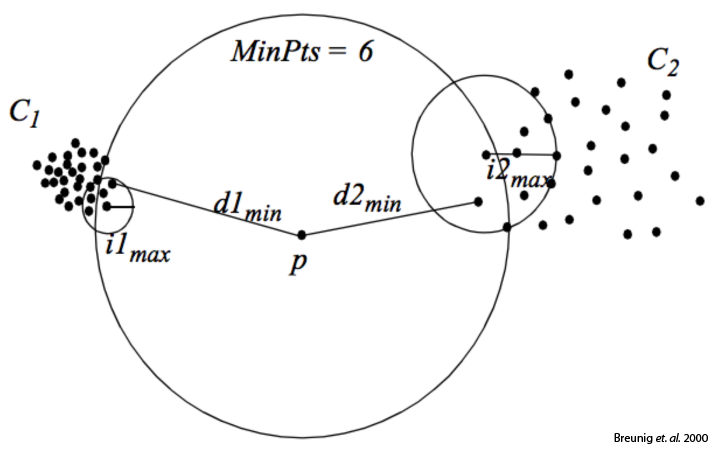

In [313]:
from IPython.display import Image
Image(filename='4.LOF.png')

We start from calculating the trimmed mean, in which the lowest and highest 5% of values from each column are dropped to prevent any outliers in a single column from skewing the mean. 

In [229]:
# calculate the trimmed mean and mean absolute deviation of each column 
def trimmean(array_in, percent=0.1):
    n = len(array_in)    
    array_in.sort()
    if round(n*percent) % 2 == 0:
        rm_n = round(n*percent)
    else:
        rm_n = round(n*percent) - 1
    rm_idx = int(rm_n/2)
    array_trimmed = array_in[rm_idx:n-rm_idx]
    return array_trimmed.mean()

trimmed_mean = []
mean_abs_dist = []
for f in df_supplier.columns:
    array_f = np.array(df_supplier[f])
    m = trimmean(array_f)
    trimmed_mean.append(m)
    dist = 0
    for i in range(len(array_f)):
        dist += abs(array_f[i] - m)
    mean_abs_dist.append(dist/len(array_f))
    
df_scale_parameters = pd.DataFrame([trimmed_mean, mean_abs_dist], 
                                    columns=df_supplier.columns,
                                    index=['Trimmed Mean', 'Mean Absolute Distance'])
df_scale_parameters

,Operate Own Transpo?,Counterintel?,Jimbo,Stevie,Margalo,Criminal Record?,Need to meet?,# Past Deals w/ Them,Max Qty Avail,Price ($/kg),Border Method_GO-FAST BOAT,Border Method_MULE,Border Method_RESERVATION,Border Method_SHIPPING CONTAINER,Border Method_SUB
Trimmed Mean,-0.448889,-0.742222,0.217778,-0.493333,-0.022222,-0.146667,0.600000,0.484444,1168.671111,7184.168889,-0.662222,-0.706667,-0.626667,-0.511111,-0.813333
Mean Absolute Distance,0.817921,0.502204,0.957144,0.780080,0.999554,0.980562,0.674699,0.877483,814.029362,216.565747,0.603730,0.548755,0.645141,0.763945,0.402249


In [230]:
# Center each column to 0 and rescale based on the mean absolute distance
df_supplier_scaled = df_supplier
for f in range(df_supplier.shape[1]):
    for i in range(df_supplier.shape[0]):
        trimmed_mean_f = df_scale_parameters.iloc[0, f]
        mean_abs_dist_f = df_scale_parameters.iloc[1, f]
        df_supplier_scaled.iloc[i, f] = (df_supplier.iloc[i, f] - trimmed_mean_f)/mean_abs_dist_f
        
df_supplier_scaled.head()

,Operate Own Transpo?,Counterintel?,Jimbo,Stevie,Margalo,Criminal Record?,Need to meet?,# Past Deals w/ Them,Max Qty Avail,Price ($/kg),Border Method_GO-FAST BOAT,Border Method_MULE,Border Method_RESERVATION,Border Method_SHIPPING CONTAINER,Border Method_SUB
Name,,,,,,,,,,,,,,,
Abraham,-0.673795,-0.513293,-1.272303,-0.649506,-0.978214,1.169397,0.592857,-0.552084,-0.548716,-0.730350,-0.559484,-0.534543,-0.578685,1.978037,-0.464058
Aleksey,-0.673795,-0.513293,-1.272303,-0.649506,-0.978214,-0.870249,0.592857,-0.552084,-0.326366,-1.515331,2.753252,-0.534543,-0.578685,-0.639953,-0.464058
Alex,1.771430,-0.513293,0.817246,-0.649506,-0.978214,-0.870249,0.592857,-0.552084,-0.714558,-0.416358,-0.559484,3.110070,-0.578685,-0.639953,-0.464058
Alexandr,-0.673795,-0.513293,-1.272303,-0.649506,-0.978214,-0.870249,0.592857,0.587539,-0.260029,-0.628765,-0.559484,-0.534543,-0.578685,1.978037,-0.464058
Alexey,-0.673795,-0.513293,0.817246,-0.649506,-0.978214,-0.870249,0.592857,-0.552084,-0.219490,-0.351713,-0.559484,3.110070,-0.578685,-0.639953,-0.464058


In [271]:
# Compute Euclidean distance between each supplier 
n_suppliers = df_supplier.shape[0]
df_dist = pd.DataFrame(np.zeros((n_suppliers, n_suppliers)), 
                       columns=df_supplier.index, 
                       index=df_supplier.index 
                      )
for i in range(n_suppliers):
    for j in range(i, n_suppliers):
        vi = df_supplier_scaled.iloc[i, :]
        vj = df_supplier_scaled.iloc[j, :]
        df_dist.iloc[i, j] = np.linalg.norm(vi - vj)
        df_dist.iloc[j, i] = df_dist.iloc[i, j]

In [272]:
df_dist.iloc[:10, :10]

Name,Abraham,Aleksey,Alex,Alexandr,Alexey,Alina,Alyona,Amado,Amro,Anastasia
Name,,,,,,,,,,
Abraham,0.000000,4.759610,5.896497,2.356386,5.377287,5.588416,5.148503,4.691479,3.549042,3.827116
Aleksey,4.759610,0.000000,5.996767,4.462873,5.476229,5.665806,6.126529,5.481194,6.148302,6.175915
Alex,5.896497,5.996767,0.000000,5.659760,2.495676,6.624080,3.387346,6.590194,5.863464,5.328530
Alexandr,2.356386,4.462873,5.659760,0.000000,5.087282,5.329943,5.624578,4.744208,4.223630,4.479981
Alexey,5.377287,5.476229,2.495676,5.087282,0.000000,6.161834,2.280245,6.139028,6.348928,5.864806
Alina,5.588416,5.665806,6.624080,5.329943,6.161834,0.000000,6.599150,4.528833,5.940034,6.138945
Alyona,5.148503,6.126529,3.387346,5.624578,2.280245,6.599150,0.000000,6.039408,5.883156,5.557544
Amado,4.691479,5.481194,6.590194,4.744208,6.139028,4.528833,6.039408,0.000000,6.042665,6.107624
Amro,3.549042,6.148302,5.863464,4.223630,6.348928,5.940034,5.883156,6.042665,0.000000,2.349058


In [273]:
# convert the distance map to row oriented ranking 
def rank(array_in):
    n = len(array_in)
    temp = array_in.argsort()
    ranks = np.empty(n, int)
    ranks[temp] = np.arange(n)
    return ranks

df_rank = df_dist.copy()
for i in range(n_suppliers):
    df_rank.iloc[i, :] = rank(np.array(df_dist.iloc[i, :]))
    
df_rank.iloc[:10, :10]

Name,Abraham,Aleksey,Alex,Alexandr,Alexey,Alina,Alyona,Amado,Amro,Anastasia
Name,,,,,,,,,,
Abraham,0,68,165,16,118,145,94,59,42,46
Aleksey,49,0,139,40,99,114,153,100,156,158
Alex,103,119,0,76,11,175,24,174,94,56
Alexandr,8,56,133,0,83,108,131,63,46,58
Alexey,81,92,15,60,0,146,14,144,165,131
Alina,97,110,182,83,150,0,181,44,129,147
Alyona,60,139,27,91,10,177,0,133,110,88
Amado,48,81,176,52,147,42,129,0,134,143
Amro,14,157,123,38,176,135,125,145,0,3


“The reason why this approach is called Local Outlier Factors is because it compares how dense a local neighborhood of points is gathered around you to how dense the neighborhoods are around those points neighboring you. If your neighborhood is  bit watery compared to the neighborhoods around you, then you’re an outlier. The people you consider your friends, don’t consider you much of a friend.”

In [294]:
# compute the reach distance 
n_neighbor = 5
def find_reach_dist(array_in, n_neighbor=n_neighbor):
    array_in.sort()
    return array_in[n_neighbor]

reach_dist = []
df_reach_dist = df_dist.copy()
for i in range(n_suppliers):
    reach_dist_i = find_reach_dist(np.array(df_dist.iloc[i, :]))
    reach_dist.append(reach_dist_i)
    for j in range(n_suppliers):
        if df_reach_dist.iloc[i, j] <= reach_dist_i:
            df_reach_dist.iloc[i, j] = reach_dist_i


In [295]:
df_reach_dist.iloc[:10, :10]

Name,Abraham,Aleksey,Alex,Alexandr,Alexey,Alina,Alyona,Amado,Amro,Anastasia
Name,,,,,,,,,,
Abraham,1.031999,4.759610,5.896497,2.356386,5.377287,5.588416,5.148503,4.691479,3.549042,3.827116
Aleksey,4.759610,2.050926,5.996767,4.462873,5.476229,5.665806,6.126529,5.481194,6.148302,6.175915
Alex,5.896497,5.996767,2.073342,5.659760,2.495676,6.624080,3.387346,6.590194,5.863464,5.328530
Alexandr,2.356386,4.462873,5.659760,2.336651,5.087282,5.329943,5.624578,4.744208,4.223630,4.479981
Alexey,5.377287,5.476229,2.495676,5.087282,1.046749,6.161834,2.280245,6.139028,6.348928,5.864806
Alina,5.588416,5.665806,6.624080,5.329943,6.161834,2.143644,6.599150,4.528833,5.940034,6.138945
Alyona,5.148503,6.126529,3.387346,5.624578,2.280245,6.599150,2.059841,6.039408,5.883156,5.557544
Amado,4.691479,5.481194,6.590194,4.744208,6.139028,4.528833,6.039408,3.475469,6.042665,6.107624
Amro,3.549042,6.148302,5.863464,4.223630,6.348928,5.940034,5.883156,6.042665,2.649667,2.649667


“And now that we have all our Reach Distances set, we’re ready to finish this calculation up,” I said, “We know that the reach distance to my five neighbors with respect to me is just the distance to the fifth and farthest in the neighborhood. But what’s my reach distance with respect to them? If their neighborhood is smaller than mine, i.e. their neighbors are closer to them than mine to me, then while they’re inside my ‘city walls,’ I’m outside theirs.”

In [292]:
# Calculate average reachability distance with respect to neighbors
avg_reach_dist = []
for i in range(n_suppliers):
    dist = 0
    for j in range(n_suppliers):
        if df_rank.iloc[i, j] <= n_neighbor and df_rank.iloc[i, j] != 0:
            dist += df_reach_dist.iloc[i, j]
    avg_reach_dist.append(dist/n_neighbor)

# Local outlier density 
LOD = [1/x for x in avg_reach_dist]

In [296]:
# Local outlier factor 
LOF = []
for i in range(n_suppliers):
    LOF_i = 0
    for j in range(n_suppliers):
        if df_rank.iloc[i, j] <= n_neighbor and df_rank.iloc[i, j] != 0:
            LOF_i += LOD[j]/LOD[i]
    LOF.append(LOF_i/n_neighbor)

In [308]:
df_LOF = pd.DataFrame([avg_reach_dist, LOD, LOF], 
                      columns=df_dist.index,
                      index=['Avg reach distance of neighbors', 'Local outlier density', 'Local outlier factor'])

In [310]:
df_LOF.transpose().sort(['Local outlier factor'], ascending=False)

,Avg reach distance of neighbors,Local outlier density,Local outlier factor
Name,,,
Zhenli Ye Gon,6.319099,0.158250,2.124889
Rizzo,5.002806,0.199888,1.952827
Nina,3.986064,0.250874,1.905439
Gleb,2.505591,0.399108,1.848563
Jimmy Two Times,1.926785,0.518999,1.770049
Sergey,3.898432,0.256513,1.758208
Molly,3.705589,0.269863,1.750308
Dmitry,3.657844,0.273385,1.696936
De Coco,3.920705,0.255056,1.683879
